In [1]:
from all_functions import * 
from sklearn.decomposition import PCA
import copy
from scipy.linalg import eigh
from sklearn.linear_model import LinearRegression

In [2]:
"""
This new functions takes the following inputs: 

    name -- the name of the Y variables, should be within double quote
    ncomps -- number of principal components to be used 
    error_comps -- number of error components to be used 
    outlier_remove -- a logical variable indicating whether to remove outliers 
    
This function select the Y variable based on the input name, and set X as 
all other variables. 

"""
def FRED_MD_DATA_PREP(name, ncomps = 5, error_comps = 5, outlier_remove = False):
   
    """
    Read the entire data
    """
    
    data = pd.read_csv('Transformed_na_removed.csv')
    
    """
    Set the Y axis to be the column of given name in the input, 
    remove that column and set the rest of the matrix as X. 
    Finally, do PCA on the X matrix. 
    
    """
    
    Y_axis = name
    X = copy.deepcopy(data)
    X.pop(name)
    X = X.to_numpy()
    n_data = X.shape[0]
    Y = data[name].to_numpy()
    W, V = eigh(X @ X.T)
    F_hat = np.sqrt(n_data) * V[:,-ncomps:] # select last ncomps columns of V
    B_hat = (1/n_data) * (X.T @ F_hat)
    
    if error_comps > 0:
        
        """
        First we project out the space of principal components
        to estimate the idiosyncratic errors. 
        """
        
#         loadings = X.T @ X_pca @ np.linalg.inv(X_pca.T @ X_pca) # OLS of X on X.pca
#         errors = X - X_pca @ loadings.T # OLS residuals
        U_hat = X - (F_hat @ B_hat.T)
        model = LinearRegression()
        model.fit(F_hat, Y)
        Y_u = Y - model.predict(F_hat)
        
        
        """
            Next we apply conditional SURE independent screening to select the 
            idiosyncratic components.
        """
       
        def cor_cal(x):
            return np.corrcoef(x, Y_u)[0, 1]
        
        cor_vec = np.apply_along_axis(cor_cal, 0, U_hat)
        idx = np.argsort(-np.abs(cor_vec))
        errors_to_add = U_hat[:,idx[:error_comps]]
        Data = np.hstack([F_hat, errors_to_add, Y.reshape(-1, 1)])
    
    else:
        Data = np.hstack([F_hat, Y.reshape(-1, 1)])
    
    if outlier_remove:
        Q1 = np.percentile(Y, 25, method = 'midpoint')
        Q3 = np.percentile(Y, 75, method = 'midpoint')
        IQR = Q3 - Q1
        upper=Q3+1.5*IQR
        upper_array=np.array(Y<=upper)
        lower=Q1-1.5*IQR
        lower_array=np.array(Y>=lower)
        index_keep = upper_array & lower_array
        Data = Data[index_keep[:,0].tolist(),:]
        print("The number of data being removed is ", Y.shape[0]-Data.shape[0])
        
    return Data, Y_axis

In [4]:
def UTOPIA_FRED_MD_MULTIVARIATE(Data, shrink = True):
    train_idx = int(Data.shape[0] * 0.8)
    train_data, test_data = np.split(Data, [train_idx])
#     X_pre = train_data[:,:-1]
#     Y_pre = train_data[:,-1].reshape(-1,1)
#     X_opt = train_data[:,:-1]
#     Y_opt = train_data[:,-1].reshape(-1,1)
#     X_adj = train_data[:,:-1]
#     Y_adj = train_data[:,-1].reshape(-1,1)
#     X_t = test_data[:,:-1]
#     Y_t = test_data[:,-1].reshape(-1,1)
    
    X_pre = train_data[:300,:-1]
    Y_pre = train_data[:300,-1].reshape(-1,1)
    X_opt = train_data[:300,:-1]
    Y_opt = train_data[:300,-1].reshape(-1,1)
    X_adj = train_data[300:,:-1]
    Y_adj = train_data[300:,-1].reshape(-1,1)
    X_t = test_data[:,:-1]
    Y_t = test_data[:,-1].reshape(-1,1)


    n_pre = len(Y_pre)
    n_opt = len(Y_opt)
    n_adj = len(Y_adj)
    n_t = len(Y_t)

    # Obtain mean estimator
    known_mean = "False"
    if known_mean == "True":
        M_pre = np.zeros(n_pre).reshape(-1,1)
        M_opt = np.zeros(n_opt).reshape(-1,1)
        M_adj = np.zeros(n_adj).reshape(-1,1)
        M_t = np.zeros(n_t).reshape(-1,1)
    else:
        est_type = "NN1"
        M_pre, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)

    # Obtain variance estimator
    var_opt, var_adj, var_t = var_est(X_pre,Y_pre,M_pre,X_opt,X_adj,X_t, max_depth = 5, est_type ="RF")


    # Obtain quantile estimators
    quantile = [0.05,0.35,0.65,0.95]
    m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_pre,X_opt,X_adj,X_t)
    m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_pre,X_opt,X_adj,X_t)
    m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_pre,X_opt,X_adj,X_t)
    m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_pre,X_opt,X_adj,X_t)

    # construct estimator matrix
    E_opt = np.hstack(((Q1_opt-M_opt)**2, (Q2_opt-M_opt)**2, (Q3_opt-M_opt)**2, (Q4_opt-M_opt)**2, var_opt.reshape(-1, 1)))
    E_opt = E_opt.T
    E_adj = np.hstack(((Q1_adj-M_adj)**2, (Q2_adj-M_adj)**2, (Q3_adj-M_adj)**2, (Q4_adj-M_adj)**2, var_adj.reshape(-1, 1)))
    E_adj = E_adj.T
    E_t = np.hstack(((Q1_t-M_t)**2, (Q2_t-M_t)**2, (Q3_t-M_t)**2, (Q4_t-M_t)**2, var_t.reshape(-1, 1)))
    E_t = E_t.T


    # solve optimization problem

    optimal_weight, V100_adj, V100_t= solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "aug", E_opt, E_adj, E_t)
    # opt_sol, V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_poly", degree = 2)
    # opt_sol, V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_rbf", sigma = 1)

    # adjust interval
    if shrink: 
        alpha = 0.05
        delta = interval_adj_2(X_adj,Y_adj,M_adj,V100_adj,alpha,stepsize = 0.001)

        # plot
        V_alpha_t = delta*V100_t
    else:
        V_alpha_t = V100_t
    
    coverage = (np.power(Y_t[:,0]-M_t[:,0], 2) <= V_alpha_t[:,0]).mean()
    bandwidth = np.mean(V_alpha_t[:,0])
    print("The overall coverage for UTOPIA is", coverage)
    print("Mean bandwidth on test data for UTOPIA is", bandwidth)
    return X_t,Y_t,M_t,V_alpha_t,coverage,bandwidth

In [5]:
def LQR_FRED_MD_MULTIVARIATE(Data):
    train_idx = int(Data.shape[0] * 0.8)
    train_data, test_data = np.split(Data, [train_idx])

    X_lin = train_data[:,:-1]
    Y_lin = train_data[:,-1].reshape(-1,1)
    y_lin = Y_lin[:,0]
    X_quantile = train_data[:,:-1]
    Y_quantile = train_data[:,-1].reshape(-1,1)
    X_test = test_data[:,:-1]
    Y_test = test_data[:,-1].reshape(-1,1)

    # Estimate the mean using NN1
    est_type = "NN1"
    M_quantile, M_test = mean_est_others(est_type,X_lin,Y_lin,X_quantile,X_test)

    # Estimate the quantile
    alpha = 0.05

    model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0, solver = 'highs')
    model_quantile.fit(X_quantile, (Y_quantile-M_quantile).reshape(-1))
    Q_test = model_quantile.predict(X_test)


    V_test = Q_test**2
    V_test = V_test.reshape(-1,1)
    coverage = (np.power(Y_test[:,0]-M_test[:,0], 2) <= V_test[:,0]).mean()
    bandwidth = np.mean(V_test[:,0])
    print("The overall coverage for LQR is", coverage)
    print("Mean bandwidth on test data for LQR is", bandwidth)
    return X_test,Y_test,M_test,V_test, coverage, bandwidth

In [6]:
def SplitCF_FRED_MD_MULTIVARIATE(Data): 
    train_idx = int(Data.shape[0] * 0.8)
    train_data, test_data = np.split(Data, [train_idx])


    X_lin = train_data[:300,:-1]
    Y_lin = train_data[:300,1].reshape(-1,1)
    y_lin = Y_lin[:,0]
    X_res = train_data[300:,:-1]
    Y_res = train_data[300:,1].reshape(-1,1)
    y_res = Y_res[:,0]
    X_test = test_data[:,:-1]
    Y_test = test_data[:,1].reshape(-1,1)
    y_test = Y_test[:,0]

    # Estimate the mean using NN1
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(42)
    torch.cuda.manual_seed_all(42) 
    input_dim = X_lin.shape[1]
    model = NN2(input_size=input_dim, output_size=1).to(device)
    criterion=nn.MSELoss()
    learning_rate = 0.001
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(1000):
        inputs=Variable(torch.from_numpy(X_lin))
        labels=Variable(torch.from_numpy(Y_lin))
        optimizer.zero_grad()
        outputs=model(inputs.float())
        loss=criterion(outputs.float(), labels.float())
        loss.backward()
        optimizer.step()


    Y_lin_pred = model(torch.from_numpy(X_lin).float())
    Y_lin_pred = Y_lin_pred.detach().cpu().numpy().reshape(-1,1)

    Y_res_hat = model(torch.from_numpy(X_res).float())
    Y_res_hat = Y_res_hat.detach().cpu().numpy().reshape(-1,1)

    Y_test_hat = model(torch.from_numpy(X_test).float())
    Y_test_hat = Y_test_hat.detach().cpu().numpy().reshape(-1,1)


#     est_type = "NN1"
#     Y_res_pred, M_test = mean_est_others(est_type,X_lin,Y_lin,X_res,X_test)
#     y_res_pred = Y_res_pred[:,0]

    # Calculate the conformity scores
    resid_mean = np.abs(Y_lin.reshape(-1) - Y_lin_pred.reshape(-1))
    
    ########################### RF based conditional variance estimator ##########################

    var_model = RandomForestRegressor(n_estimators = 1000, max_depth = 5, random_state = 42)
    #var_model = RandomForestRegressor(n_estimators = 1000, max_depth = 3)
    var_model.fit(X_lin, resid_mean ** 2)

    var_mean_hat = var_model.predict(X_lin)
    var_res_hat = var_model.predict(X_res)
    var_test_hat = var_model.predict(X_test)

    alpha = 0.05
    residuals = np.abs(Y_res[:,0] - Y_res_hat[:,0])/((var_res_hat.reshape(-1) ** 0.5) + 1e-10)
    k = int((1 - alpha) * len(residuals))
    residuals_sorted = np.sort(residuals)
    threshold = residuals_sorted[k]

    v_test = (threshold**2)*var_test_hat
    V_test = v_test.reshape(-1,1)


#     alpha = 0.05  # 95% confidence level
#     k = int((1 - alpha) * len(y_lin))
#     residuals_sorted = np.sort(residuals)
#     threshold = residuals_sorted[k]

    # Calculate the prediction interval
#     v_test = (threshold**2)*np.ones(len(y_test))
#     V_test = v_test.reshape(-1,1)
    
    
    
    coverage = (np.power(Y_test[:,0]-Y_test_hat[:,0], 2) <= V_test[:,0]).mean()
    bandwidth = np.mean(V_test[:,0])
    print("The overall coverage for SplitCF is", coverage)
    print("Mean bandwidth on test data for SplitCF is", bandwidth)
    return X_test,Y_test,Y_test_hat,V_test,coverage,bandwidth

In [7]:
data = pd.read_csv('Transformed_na_removed.csv')
col = data.columns

In [20]:
data['Unnamed: 0']

0        5
1        6
2       12
3       16
4       17
      ... 
449    501
450    502
451    503
452    504
453    505
Name: Unnamed: 0, Length: 454, dtype: int64

In [12]:
output_coverage = np.zeros((len(data.columns)-1, 3))
output_bandwidth = np.zeros((len(data.columns)-1, 3))

for j in range(1, len(data.columns)):
    idx = data.columns[j]
    Data, Y_axis = FRED_MD_DATA_PREP(idx, ncomps=2, error_comps=3)
    
    X_t,Y_t,M_t,V_alpha_t, coverage_utopia, bandwidth_utopia = UTOPIA_FRED_MD_MULTIVARIATE(Data, shrink = True)
    X_test,Y_test,M_test,V_test,coverage_lqr, bandwidth_lqr = LQR_FRED_MD_MULTIVARIATE(Data)
    X_test,Y_test,M_test,V_test, coverage_split, bandwidth_split = SplitCF_FRED_MD_MULTIVARIATE(Data)
    
    output_coverage[j-1,] = np.array([coverage_utopia, coverage_lqr, coverage_split]).reshape(-1)
    output_bandwidth[j-1,] = np.array([bandwidth_utopia, bandwidth_lqr, bandwidth_split]).reshape(-1)
    print(j, "th index is done!")

/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.978021978021978
Mean bandwidth on test data for UTOPIA is 0.0006753001409418569
The overall coverage for LQR is 0.5934065934065934
Mean bandwidth on test data for LQR is 0.00032676865626071836
The overall coverage for SplitCF is 0.978021978021978
Mean bandwidth on test data for SplitCF is 0.0011209154525900873
1 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.9340659340659341
Mean bandwidth on test data for UTOPIA is 0.0005659911463285356
The overall coverage for LQR is 0.8131868131868132
Mean bandwidth on test data for LQR is 0.000453151498426142
The overall coverage for SplitCF is 0.6703296703296703
Mean bandwidth on test data for SplitCF is 0.00025149170716585247
2 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.6153846153846154
Mean bandwidth on test data for UTOPIA is 0.00047415708805083047
The overall coverage for LQR is 0.6263736263736264
Mean bandwidth on test data for LQR is 0.00033561385091813333
The overall coverage for SplitCF is 0.9010989010989011
Mean bandwidth on test data for SplitCF is 0.00036794931547540715
3 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 1.0
Mean bandwidth on test data for UTOPIA is 0.0012689237428871402
The overall coverage for LQR is 0.7582417582417582
Mean bandwidth on test data for LQR is 0.0005488280599389839
The overall coverage for SplitCF is 0.9230769230769231
Mean bandwidth on test data for SplitCF is 0.0007156112868426588
4 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.9340659340659341
Mean bandwidth on test data for UTOPIA is 0.0023194293861676777
The overall coverage for LQR is 0.7142857142857143
Mean bandwidth on test data for LQR is 0.000335066073369714
The overall coverage for SplitCF is 0.8021978021978022
Mean bandwidth on test data for SplitCF is 0.00016706965541510833
5 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.9230769230769231
Mean bandwidth on test data for UTOPIA is 0.0008160270726625573
The overall coverage for LQR is 0.6153846153846154
Mean bandwidth on test data for LQR is 0.0002911076629457759
The overall coverage for SplitCF is 0.7912087912087912
Mean bandwidth on test data for SplitCF is 0.00025930415047577775
6 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.9560439560439561
Mean bandwidth on test data for UTOPIA is 0.0006049939838274668
The overall coverage for LQR is 0.6263736263736264
Mean bandwidth on test data for LQR is 0.0002863416566653451
The overall coverage for SplitCF is 0.945054945054945
Mean bandwidth on test data for SplitCF is 0.0005763463927884101
7 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.967032967032967
Mean bandwidth on test data for UTOPIA is 0.0006541448987031723
The overall coverage for LQR is 0.6373626373626373
Mean bandwidth on test data for LQR is 0.00029394853897880417
The overall coverage for SplitCF is 0.9120879120879121
Mean bandwidth on test data for SplitCF is 0.000492394568525913
8 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.945054945054945
Mean bandwidth on test data for UTOPIA is 0.0007410239216670729
The overall coverage for LQR is 0.6483516483516484
Mean bandwidth on test data for LQR is 0.00037959893654111753
The overall coverage for SplitCF is 0.945054945054945
Mean bandwidth on test data for SplitCF is 0.0006019025186116109
9 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.9560439560439561
Mean bandwidth on test data for UTOPIA is 0.007003354651289818
The overall coverage for LQR is 0.8241758241758241
Mean bandwidth on test data for LQR is 0.000879465324214168
The overall coverage for SplitCF is 0.8241758241758241
Mean bandwidth on test data for SplitCF is 0.00018131151288971995
10 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.6483516483516484
Mean bandwidth on test data for UTOPIA is 0.00046424251863182083
The overall coverage for LQR is 0.6703296703296703
Mean bandwidth on test data for LQR is 0.0003481529823397045
The overall coverage for SplitCF is 0.8241758241758241
Mean bandwidth on test data for SplitCF is 0.00032555989424645467
11 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.978021978021978
Mean bandwidth on test data for UTOPIA is 0.0013687196129723888
The overall coverage for LQR is 0.8461538461538461
Mean bandwidth on test data for LQR is 0.0004325507625738421
The overall coverage for SplitCF is 0.9230769230769231
Mean bandwidth on test data for SplitCF is 0.0005017465609265496
12 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.978021978021978
Mean bandwidth on test data for UTOPIA is 0.0007132800712596832
The overall coverage for LQR is 0.5384615384615384
Mean bandwidth on test data for LQR is 0.00020491530848673454
The overall coverage for SplitCF is 0.7802197802197802
Mean bandwidth on test data for SplitCF is 0.0005977131684493337
13 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.989010989010989
Mean bandwidth on test data for UTOPIA is 0.0007642714180998996
The overall coverage for LQR is 0.7252747252747253
Mean bandwidth on test data for LQR is 0.00015925727972275654
The overall coverage for SplitCF is 0.5384615384615384
Mean bandwidth on test data for SplitCF is 0.00015709633772787086
14 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.945054945054945
Mean bandwidth on test data for UTOPIA is 0.000929976492326357
The overall coverage for LQR is 0.7912087912087912
Mean bandwidth on test data for LQR is 0.000238874608890947
The overall coverage for SplitCF is 0.6483516483516484
Mean bandwidth on test data for SplitCF is 0.0008022377348794854
15 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 1.0
Mean bandwidth on test data for UTOPIA is 0.0004827276759457582
The overall coverage for LQR is 0.6593406593406593
Mean bandwidth on test data for LQR is 0.0002107916665064654
The overall coverage for SplitCF is 0.7692307692307693
Mean bandwidth on test data for SplitCF is 0.0009261825520244164
16 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.9560439560439561
Mean bandwidth on test data for UTOPIA is 0.008096534518537188
The overall coverage for LQR is 0.8791208791208791
Mean bandwidth on test data for LQR is 0.004592865109078388
The overall coverage for SplitCF is 0.6483516483516484
Mean bandwidth on test data for SplitCF is 0.0001879889256127099
17 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.9560439560439561
Mean bandwidth on test data for UTOPIA is 0.0021570731596212496
The overall coverage for LQR is 0.5714285714285714
Mean bandwidth on test data for LQR is 0.00039608711026432213
The overall coverage for SplitCF is 0.6703296703296703
Mean bandwidth on test data for SplitCF is 0.0005321972607713932
18 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.8901098901098901
Mean bandwidth on test data for UTOPIA is 0.6470696861889389
The overall coverage for LQR is 0.45054945054945056
Mean bandwidth on test data for LQR is 0.12421328709800918
The overall coverage for SplitCF is 0.9340659340659341
Mean bandwidth on test data for SplitCF is 0.0006139791172219808
19 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.9120879120879121
Mean bandwidth on test data for UTOPIA is 234909.2085774704
The overall coverage for LQR is 0.7582417582417582
Mean bandwidth on test data for LQR is 192048.06299644156
The overall coverage for SplitCF is 0.14285714285714285
Mean bandwidth on test data for SplitCF is 0.01580979059608304
20 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.7252747252747253
Mean bandwidth on test data for UTOPIA is 0.001276238356517905
The overall coverage for LQR is 0.6593406593406593
Mean bandwidth on test data for LQR is 0.0006798612827539378
The overall coverage for SplitCF is 0.8681318681318682
Mean bandwidth on test data for SplitCF is 0.0004924971509662158
21 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.9230769230769231
Mean bandwidth on test data for UTOPIA is 0.0007333767097544128
The overall coverage for LQR is 0.7472527472527473
Mean bandwidth on test data for LQR is 0.00040558676786649753
The overall coverage for SplitCF is 0.8351648351648352
Mean bandwidth on test data for SplitCF is 0.00034663255787260855
22 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.8461538461538461
Mean bandwidth on test data for UTOPIA is 0.0005025490254920425
The overall coverage for LQR is 0.7252747252747253
Mean bandwidth on test data for LQR is 0.0003533452680868301
The overall coverage for SplitCF is 0.8571428571428571
Mean bandwidth on test data for SplitCF is 0.00041333069656318214
23 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.967032967032967
Mean bandwidth on test data for UTOPIA is 0.08484105049551857
The overall coverage for LQR is 0.7362637362637363
Mean bandwidth on test data for LQR is 0.019826949334324315
The overall coverage for SplitCF is 0.7252747252747253
Mean bandwidth on test data for SplitCF is 0.00020527462745648724
24 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.8351648351648352
Mean bandwidth on test data for UTOPIA is 2.114419813836735
The overall coverage for LQR is 0.7252747252747253
Mean bandwidth on test data for LQR is 1.5194779068796052
The overall coverage for SplitCF is 0.8461538461538461
Mean bandwidth on test data for SplitCF is 0.00024986592305370194
25 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.8461538461538461
Mean bandwidth on test data for UTOPIA is 0.011828909869020406
The overall coverage for LQR is 0.7582417582417582
Mean bandwidth on test data for LQR is 0.007041529139311957
The overall coverage for SplitCF is 0.7692307692307693
Mean bandwidth on test data for SplitCF is 0.0004307553015848432
26 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.989010989010989
Mean bandwidth on test data for UTOPIA is 0.021615049037790907
The overall coverage for LQR is 0.8901098901098901
Mean bandwidth on test data for LQR is 0.010805841692864276
The overall coverage for SplitCF is 0.8461538461538461
Mean bandwidth on test data for SplitCF is 0.0005198723294620311
27 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.978021978021978
Mean bandwidth on test data for UTOPIA is 0.04928705511632646
The overall coverage for LQR is 0.7912087912087912
Mean bandwidth on test data for LQR is 0.0006968387850623155
The overall coverage for SplitCF is 0.8461538461538461
Mean bandwidth on test data for SplitCF is 0.0002691898425481614
28 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.9230769230769231
Mean bandwidth on test data for UTOPIA is 0.020975516212059387
The overall coverage for LQR is 0.8351648351648352
Mean bandwidth on test data for LQR is 0.009724356962800247
The overall coverage for SplitCF is 0.5054945054945055
Mean bandwidth on test data for SplitCF is 0.0005062342346404554
29 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.8681318681318682
Mean bandwidth on test data for UTOPIA is 0.00652152793544809
The overall coverage for LQR is 0.6923076923076923
Mean bandwidth on test data for LQR is 0.002969911202638852
The overall coverage for SplitCF is 0.8351648351648352
Mean bandwidth on test data for SplitCF is 0.0008531723793504892
30 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.8241758241758241
Mean bandwidth on test data for UTOPIA is 0.0057128190784787045
The overall coverage for LQR is 0.8351648351648352
Mean bandwidth on test data for LQR is 0.005862958337349016
The overall coverage for SplitCF is 0.8791208791208791
Mean bandwidth on test data for SplitCF is 0.00023030523342097633
31 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.6373626373626373
Mean bandwidth on test data for UTOPIA is 0.0006156151337261949
The overall coverage for LQR is 0.6043956043956044
Mean bandwidth on test data for LQR is 0.00029965001118511354
The overall coverage for SplitCF is 0.9560439560439561
Mean bandwidth on test data for SplitCF is 0.000701160161520837
32 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.978021978021978
Mean bandwidth on test data for UTOPIA is 0.001159824757478969
The overall coverage for LQR is 0.6263736263736264
Mean bandwidth on test data for LQR is 0.0002756907830798014
The overall coverage for SplitCF is 0.9560439560439561
Mean bandwidth on test data for SplitCF is 0.000769205895851628
33 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.8021978021978022
Mean bandwidth on test data for UTOPIA is 0.0006933170561775742
The overall coverage for LQR is 0.5824175824175825
Mean bandwidth on test data for LQR is 0.0002451485749766839
The overall coverage for SplitCF is 0.8131868131868132
Mean bandwidth on test data for SplitCF is 0.0002743049079216248
34 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 1.0
Mean bandwidth on test data for UTOPIA is 0.0008089702668225754
The overall coverage for LQR is 0.6043956043956044
Mean bandwidth on test data for LQR is 0.0002813755035225661
The overall coverage for SplitCF is 0.945054945054945
Mean bandwidth on test data for SplitCF is 0.0007198481837059061
35 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.989010989010989
Mean bandwidth on test data for UTOPIA is 0.0007687014913691985
The overall coverage for LQR is 0.5824175824175825
Mean bandwidth on test data for LQR is 0.00027026612978239036
The overall coverage for SplitCF is 0.8791208791208791
Mean bandwidth on test data for SplitCF is 0.00046025043172775174
36 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.9340659340659341
Mean bandwidth on test data for UTOPIA is 0.0007823091844591352
The overall coverage for LQR is 0.6373626373626373
Mean bandwidth on test data for LQR is 0.00030078956237044094
The overall coverage for SplitCF is 0.9340659340659341
Mean bandwidth on test data for SplitCF is 0.0007295392825473971
37 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.5384615384615384
Mean bandwidth on test data for UTOPIA is 0.0006305399114432427
The overall coverage for LQR is 0.6043956043956044
Mean bandwidth on test data for LQR is 0.00035331799481091053
The overall coverage for SplitCF is 0.9560439560439561
Mean bandwidth on test data for SplitCF is 0.0007612011697272075
38 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.5714285714285714
Mean bandwidth on test data for UTOPIA is 0.0005685701842856214
The overall coverage for LQR is 0.6153846153846154
Mean bandwidth on test data for LQR is 0.00029194449471918487
The overall coverage for SplitCF is 0.9560439560439561
Mean bandwidth on test data for SplitCF is 0.0006411809776978927
39 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.6703296703296703
Mean bandwidth on test data for UTOPIA is 0.0005963773770841879
The overall coverage for LQR is 0.6263736263736264
Mean bandwidth on test data for LQR is 0.00032743107519887235
The overall coverage for SplitCF is 0.945054945054945
Mean bandwidth on test data for SplitCF is 0.0006755065038246979
40 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.8131868131868132
Mean bandwidth on test data for UTOPIA is 0.0005589427966325179
The overall coverage for LQR is 0.5934065934065934
Mean bandwidth on test data for LQR is 0.00020812063917698037
The overall coverage for SplitCF is 0.9560439560439561
Mean bandwidth on test data for SplitCF is 0.0007231757406188992
41 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.978021978021978
Mean bandwidth on test data for UTOPIA is 0.0009742428677782394
The overall coverage for LQR is 0.6263736263736264
Mean bandwidth on test data for LQR is 0.0003400354827939914
The overall coverage for SplitCF is 0.945054945054945
Mean bandwidth on test data for SplitCF is 0.0006303323791937844
42 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 1.0
Mean bandwidth on test data for UTOPIA is 0.0005482281358486164
The overall coverage for LQR is 0.45054945054945056
Mean bandwidth on test data for LQR is 0.00010531284372990277
The overall coverage for SplitCF is 0.8241758241758241
Mean bandwidth on test data for SplitCF is 0.0014856442524732285
43 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.989010989010989
Mean bandwidth on test data for UTOPIA is 0.0005910090281885534
The overall coverage for LQR is 0.8791208791208791
Mean bandwidth on test data for LQR is 0.0005475177444609484
The overall coverage for SplitCF is 0.5824175824175825
Mean bandwidth on test data for SplitCF is 0.0009767503726560477
44 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.5054945054945055
Mean bandwidth on test data for UTOPIA is 70.70886266333473
The overall coverage for LQR is 0.967032967032967
Mean bandwidth on test data for LQR is 102.77529146983053
The overall coverage for SplitCF is 0.5384615384615384
Mean bandwidth on test data for SplitCF is 0.0003340080188320631
45 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.9120879120879121
Mean bandwidth on test data for UTOPIA is 0.04302538817344384
The overall coverage for LQR is 0.7912087912087912
Mean bandwidth on test data for LQR is 0.018946554971319748
The overall coverage for SplitCF is 0.8021978021978022
Mean bandwidth on test data for SplitCF is 0.00019144920400348444
46 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.1978021978021978
Mean bandwidth on test data for UTOPIA is 40.31098907779866
The overall coverage for LQR is 0.989010989010989
Mean bandwidth on test data for LQR is 61.14438957769856
The overall coverage for SplitCF is 0.7032967032967034
Mean bandwidth on test data for SplitCF is 0.00021815953194682084
47 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 1.0
Mean bandwidth on test data for UTOPIA is 26.165095809661256
The overall coverage for LQR is 0.0
Mean bandwidth on test data for LQR is 2.3525688864854284
The overall coverage for SplitCF is 0.945054945054945
Mean bandwidth on test data for SplitCF is 0.0006686071449509334
48 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 1.0
Mean bandwidth on test data for UTOPIA is 12.22224747965811
The overall coverage for LQR is 0.13186813186813187
Mean bandwidth on test data for LQR is 0.46968496173676005
The overall coverage for SplitCF is 0.9560439560439561
Mean bandwidth on test data for SplitCF is 0.0006762755823207739
49 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.989010989010989
Mean bandwidth on test data for UTOPIA is 15.083739001175864
The overall coverage for LQR is 0.0
Mean bandwidth on test data for LQR is 0.1194895170185328
The overall coverage for SplitCF is 0.5054945054945055
Mean bandwidth on test data for SplitCF is 0.0008669605057228094
50 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 1.0
Mean bandwidth on test data for UTOPIA is 19.82308126701611
The overall coverage for LQR is 0.0
Mean bandwidth on test data for LQR is 1.4290191810818673
The overall coverage for SplitCF is 0.7032967032967034
Mean bandwidth on test data for SplitCF is 0.0002480085147054279
51 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 1.0
Mean bandwidth on test data for UTOPIA is 23.261227084085867
The overall coverage for LQR is 0.0
Mean bandwidth on test data for LQR is 0.6438202677026361
The overall coverage for SplitCF is 0.945054945054945
Mean bandwidth on test data for SplitCF is 0.0006762664248296909
52 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 1.0
Mean bandwidth on test data for UTOPIA is 27.552667037889993
The overall coverage for LQR is 0.0
Mean bandwidth on test data for LQR is 1.9774564050594294
The overall coverage for SplitCF is 0.945054945054945
Mean bandwidth on test data for SplitCF is 0.0006672096730288273
53 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 1.0
Mean bandwidth on test data for UTOPIA is 11.648016071474688
The overall coverage for LQR is 0.08791208791208792
Mean bandwidth on test data for LQR is 0.30302444068734286
The overall coverage for SplitCF is 0.945054945054945
Mean bandwidth on test data for SplitCF is 0.0006742679924512673
54 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 1.0
Mean bandwidth on test data for UTOPIA is 27.71900368539246
The overall coverage for LQR is 0.01098901098901099
Mean bandwidth on test data for LQR is 0.1649204215107108
The overall coverage for SplitCF is 0.5604395604395604
Mean bandwidth on test data for SplitCF is 0.0006844385202958828
55 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 1.0
Mean bandwidth on test data for UTOPIA is 20.386855353672868
The overall coverage for LQR is 0.0
Mean bandwidth on test data for LQR is 1.0676072660603277
The overall coverage for SplitCF is 0.7032967032967034
Mean bandwidth on test data for SplitCF is 0.0002505549121966964
56 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 1.0
Mean bandwidth on test data for UTOPIA is 24.315383824815186
The overall coverage for LQR is 0.0
Mean bandwidth on test data for LQR is 0.22323654489423378
The overall coverage for SplitCF is 0.945054945054945
Mean bandwidth on test data for SplitCF is 0.0006892589404630218
57 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.8791208791208791
Mean bandwidth on test data for UTOPIA is 0.003056415054775972
The overall coverage for LQR is 0.8571428571428571
Mean bandwidth on test data for LQR is 0.0013502465410827262
The overall coverage for SplitCF is 0.7252747252747253
Mean bandwidth on test data for SplitCF is 0.00021066445543248272
58 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.8131868131868132
Mean bandwidth on test data for UTOPIA is 0.009321516260401652
The overall coverage for LQR is 0.5164835164835165
Mean bandwidth on test data for LQR is 0.004062192700798431
The overall coverage for SplitCF is 0.7692307692307693
Mean bandwidth on test data for SplitCF is 0.00021412407800145078
59 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.978021978021978
Mean bandwidth on test data for UTOPIA is 0.0022821652982550015
The overall coverage for LQR is 0.7692307692307693
Mean bandwidth on test data for LQR is 0.0005087305006380067
The overall coverage for SplitCF is 0.8901098901098901
Mean bandwidth on test data for SplitCF is 0.0002660485766956167
60 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.978021978021978
Mean bandwidth on test data for UTOPIA is 0.00229536412508005
The overall coverage for LQR is 0.8131868131868132
Mean bandwidth on test data for LQR is 0.0005372286611961776
The overall coverage for SplitCF is 0.9560439560439561
Mean bandwidth on test data for SplitCF is 0.000750515290489224
61 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.967032967032967
Mean bandwidth on test data for UTOPIA is 0.008365615838607626
The overall coverage for LQR is 0.7692307692307693
Mean bandwidth on test data for LQR is 0.0008139119505515869
The overall coverage for SplitCF is 0.9560439560439561
Mean bandwidth on test data for SplitCF is 0.000743043142455002
62 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.989010989010989
Mean bandwidth on test data for UTOPIA is 0.0036353863330402005
The overall coverage for LQR is 0.7802197802197802
Mean bandwidth on test data for LQR is 0.0006875027811749799
The overall coverage for SplitCF is 0.8791208791208791
Mean bandwidth on test data for SplitCF is 0.0002483330104556927
63 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.7362637362637363
Mean bandwidth on test data for UTOPIA is 0.0005298211154275275
The overall coverage for LQR is 0.5824175824175825
Mean bandwidth on test data for LQR is 0.0002236432739798171
The overall coverage for SplitCF is 0.7692307692307693
Mean bandwidth on test data for SplitCF is 0.0001975307210242481
64 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 1.0
Mean bandwidth on test data for UTOPIA is 0.0012265359861242363
The overall coverage for LQR is 0.7032967032967034
Mean bandwidth on test data for LQR is 0.00037318067088179605
The overall coverage for SplitCF is 0.46153846153846156
Mean bandwidth on test data for SplitCF is 0.001556509108163123
65 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.9340659340659341
Mean bandwidth on test data for UTOPIA is 0.003876573126811688
The overall coverage for LQR is 0.8021978021978022
Mean bandwidth on test data for LQR is 0.0009775010659856334
The overall coverage for SplitCF is 0.7912087912087912
Mean bandwidth on test data for SplitCF is 0.0002428503229293065
66 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 1.0
Mean bandwidth on test data for UTOPIA is 0.0030632858855642368
The overall coverage for LQR is 0.978021978021978
Mean bandwidth on test data for LQR is 0.0023213051233584403
The overall coverage for SplitCF is 0.6373626373626373
Mean bandwidth on test data for SplitCF is 0.00031768723672693247
67 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 1.0
Mean bandwidth on test data for UTOPIA is 0.015036115151541301
The overall coverage for LQR is 0.7032967032967034
Mean bandwidth on test data for LQR is 0.0007647086294527882
The overall coverage for SplitCF is 0.8571428571428571
Mean bandwidth on test data for SplitCF is 0.00022160355909814223
68 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.8021978021978022
Mean bandwidth on test data for UTOPIA is 0.0006434907414893666
The overall coverage for LQR is 0.7252747252747253
Mean bandwidth on test data for LQR is 0.00046293751311469886
The overall coverage for SplitCF is 0.5934065934065934
Mean bandwidth on test data for SplitCF is 0.0003629585163181055
69 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.8241758241758241
Mean bandwidth on test data for UTOPIA is 0.0007687119110162189
The overall coverage for LQR is 0.7692307692307693
Mean bandwidth on test data for LQR is 0.00055688387153884
The overall coverage for SplitCF is 0.8131868131868132
Mean bandwidth on test data for SplitCF is 0.00017589674761577662
70 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.6923076923076923
Mean bandwidth on test data for UTOPIA is 0.000690780012045492
The overall coverage for LQR is 0.8241758241758241
Mean bandwidth on test data for LQR is 0.0004904923249623977
The overall coverage for SplitCF is 0.9230769230769231
Mean bandwidth on test data for SplitCF is 0.0004621719953833017
71 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.967032967032967
Mean bandwidth on test data for UTOPIA is 0.0005539044253482471
The overall coverage for LQR is 0.6153846153846154
Mean bandwidth on test data for LQR is 0.00029188481584708576
The overall coverage for SplitCF is 0.9560439560439561
Mean bandwidth on test data for SplitCF is 0.0008761359672152674
72 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.989010989010989
Mean bandwidth on test data for UTOPIA is 0.0015159200102817507
The overall coverage for LQR is 0.7032967032967034
Mean bandwidth on test data for LQR is 0.0003892057132287362
The overall coverage for SplitCF is 0.7032967032967034
Mean bandwidth on test data for SplitCF is 0.0007204334330154729
73 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.9560439560439561
Mean bandwidth on test data for UTOPIA is 0.0012440749015276773
The overall coverage for LQR is 0.7802197802197802
Mean bandwidth on test data for LQR is 0.0004903609346897294
The overall coverage for SplitCF is 0.8241758241758241
Mean bandwidth on test data for SplitCF is 0.00014209548062405595
74 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 1.0
Mean bandwidth on test data for UTOPIA is 0.04136403330001768
The overall coverage for LQR is 0.6153846153846154
Mean bandwidth on test data for LQR is 0.00164080939547755
The overall coverage for SplitCF is 0.8791208791208791
Mean bandwidth on test data for SplitCF is 0.00034908201642551504
75 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 1.0
Mean bandwidth on test data for UTOPIA is 0.02381017320276644
The overall coverage for LQR is 0.989010989010989
Mean bandwidth on test data for LQR is 0.015470276825021919
The overall coverage for SplitCF is 0.8131868131868132
Mean bandwidth on test data for SplitCF is 0.0003058220238076057
76 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.8791208791208791
Mean bandwidth on test data for UTOPIA is 0.008795045225265696
The overall coverage for LQR is 0.5934065934065934
Mean bandwidth on test data for LQR is 0.005177505072766571
The overall coverage for SplitCF is 0.46153846153846156
Mean bandwidth on test data for SplitCF is 0.0008951985989292618
77 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.989010989010989
Mean bandwidth on test data for UTOPIA is 0.05359510924523084
The overall coverage for LQR is 0.6043956043956044
Mean bandwidth on test data for LQR is 0.004667471381822148
The overall coverage for SplitCF is 0.5164835164835165
Mean bandwidth on test data for SplitCF is 0.0013006118839685326
78 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 1.0
Mean bandwidth on test data for UTOPIA is 0.01710088708416916
The overall coverage for LQR is 0.5604395604395604
Mean bandwidth on test data for LQR is 0.0030374549334886087
The overall coverage for SplitCF is 0.6153846153846154
Mean bandwidth on test data for SplitCF is 0.0006748032951092316
79 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.9010989010989011
Mean bandwidth on test data for UTOPIA is 0.0023594937072128706
The overall coverage for LQR is 0.6263736263736264
Mean bandwidth on test data for LQR is 0.0008660639982174471
The overall coverage for SplitCF is 0.5714285714285714
Mean bandwidth on test data for SplitCF is 0.0009284994891932426
80 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.967032967032967
Mean bandwidth on test data for UTOPIA is 0.016967612253301595
The overall coverage for LQR is 0.7472527472527473
Mean bandwidth on test data for LQR is 0.002922228029398908
The overall coverage for SplitCF is 0.5384615384615384
Mean bandwidth on test data for SplitCF is 0.0007848847994285834
81 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 1.0
Mean bandwidth on test data for UTOPIA is 0.021726868060205053
The overall coverage for LQR is 0.8791208791208791
Mean bandwidth on test data for LQR is 0.01228320588004433
The overall coverage for SplitCF is 0.42857142857142855
Mean bandwidth on test data for SplitCF is 0.0013641142048149617
82 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.989010989010989
Mean bandwidth on test data for UTOPIA is 0.03640618700092621
The overall coverage for LQR is 0.8021978021978022
Mean bandwidth on test data for LQR is 0.006639511218665251
The overall coverage for SplitCF is 0.5384615384615384
Mean bandwidth on test data for SplitCF is 0.0012111315068112764
83 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.989010989010989
Mean bandwidth on test data for UTOPIA is 0.018263758562953265
The overall coverage for LQR is 0.7472527472527473
Mean bandwidth on test data for LQR is 0.006171032690104151
The overall coverage for SplitCF is 0.43956043956043955
Mean bandwidth on test data for SplitCF is 0.0011474413635010252
84 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 1.0
Mean bandwidth on test data for UTOPIA is 0.06686971982426367
The overall coverage for LQR is 0.9230769230769231
Mean bandwidth on test data for LQR is 0.018818112038202352
The overall coverage for SplitCF is 0.5274725274725275
Mean bandwidth on test data for SplitCF is 0.0002733486187376959
85 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 1.0
Mean bandwidth on test data for UTOPIA is 0.4293548390770994
The overall coverage for LQR is 1.0
Mean bandwidth on test data for LQR is 0.28440248637160404
The overall coverage for SplitCF is 0.8021978021978022
Mean bandwidth on test data for SplitCF is 0.00944245914471207
86 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 1.0
Mean bandwidth on test data for UTOPIA is 0.060066141303493525
The overall coverage for LQR is 0.21978021978021978
Mean bandwidth on test data for LQR is 0.0014833305539186199
The overall coverage for SplitCF is 0.7802197802197802
Mean bandwidth on test data for SplitCF is 0.00675401845587222
87 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 1.0
Mean bandwidth on test data for UTOPIA is 0.10294329647861088
The overall coverage for LQR is 0.3516483516483517
Mean bandwidth on test data for LQR is 0.0018319442241567809
The overall coverage for SplitCF is 0.7802197802197802
Mean bandwidth on test data for SplitCF is 0.007948228191650074
88 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.9230769230769231
Mean bandwidth on test data for UTOPIA is 0.03929896186205564
The overall coverage for LQR is 0.23076923076923078
Mean bandwidth on test data for LQR is 0.0010950072861687077
The overall coverage for SplitCF is 0.8901098901098901
Mean bandwidth on test data for SplitCF is 0.0033054970179510444
89 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 1.0
Mean bandwidth on test data for UTOPIA is 0.6059385788487014
The overall coverage for LQR is 0.6703296703296703
Mean bandwidth on test data for LQR is 0.07706816849691608
The overall coverage for SplitCF is 0.8241758241758241
Mean bandwidth on test data for SplitCF is 0.015307148071240303
90 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.9340659340659341
Mean bandwidth on test data for UTOPIA is 3.9311731467142415
The overall coverage for LQR is 0.978021978021978
Mean bandwidth on test data for LQR is 0.17265116799037147
The overall coverage for SplitCF is 0.6043956043956044
Mean bandwidth on test data for SplitCF is 0.0014620722060655097
91 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 1.0
Mean bandwidth on test data for UTOPIA is 0.996863131828993
The overall coverage for LQR is 0.7362637362637363
Mean bandwidth on test data for LQR is 0.18088761304453355
The overall coverage for SplitCF is 0.4065934065934066
Mean bandwidth on test data for SplitCF is 0.004419931918339507
92 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 1.0
Mean bandwidth on test data for UTOPIA is 15.567721388414613
The overall coverage for LQR is 0.5164835164835165
Mean bandwidth on test data for LQR is 0.5200838383374997
The overall coverage for SplitCF is 0.8241758241758241
Mean bandwidth on test data for SplitCF is 0.001381708689224404
93 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.7362637362637363
Mean bandwidth on test data for UTOPIA is 0.00107852812833075
The overall coverage for LQR is 0.7582417582417582
Mean bandwidth on test data for LQR is 0.0006709449656154678
The overall coverage for SplitCF is 0.8241758241758241
Mean bandwidth on test data for SplitCF is 0.00023024764903754896
94 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.978021978021978
Mean bandwidth on test data for UTOPIA is 0.0020539117477015407
The overall coverage for LQR is 0.9340659340659341
Mean bandwidth on test data for LQR is 0.0011488155150375092
The overall coverage for SplitCF is 0.7032967032967034
Mean bandwidth on test data for SplitCF is 0.00017367846535940005
95 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.967032967032967
Mean bandwidth on test data for UTOPIA is 0.003239598722455958
The overall coverage for LQR is 0.9230769230769231
Mean bandwidth on test data for LQR is 0.0018654515256482575
The overall coverage for SplitCF is 0.9120879120879121
Mean bandwidth on test data for SplitCF is 0.00046151114211185164
96 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.9560439560439561
Mean bandwidth on test data for UTOPIA is 0.0014952651895604634
The overall coverage for LQR is 0.6373626373626373
Mean bandwidth on test data for LQR is 0.0004892710076392953
The overall coverage for SplitCF is 0.945054945054945
Mean bandwidth on test data for SplitCF is 0.0005606864897847153
97 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.978021978021978
Mean bandwidth on test data for UTOPIA is 0.00290512514673412
The overall coverage for LQR is 0.8131868131868132
Mean bandwidth on test data for LQR is 0.0008692853883507063
The overall coverage for SplitCF is 0.9010989010989011
Mean bandwidth on test data for SplitCF is 0.0004081747280551943
98 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.8901098901098901
Mean bandwidth on test data for UTOPIA is 0.0005241052920717704
The overall coverage for LQR is 0.6263736263736264
Mean bandwidth on test data for LQR is 0.0001982556418799698
The overall coverage for SplitCF is 0.9560439560439561
Mean bandwidth on test data for SplitCF is 0.0008123373294906477
99 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.9340659340659341
Mean bandwidth on test data for UTOPIA is 0.0006555045135125902
The overall coverage for LQR is 0.5824175824175825
Mean bandwidth on test data for LQR is 0.00023363454610060498
The overall coverage for SplitCF is 0.978021978021978
Mean bandwidth on test data for SplitCF is 0.001111211678362098
100 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.978021978021978
Mean bandwidth on test data for UTOPIA is 0.0010404192225967393
The overall coverage for LQR is 0.7142857142857143
Mean bandwidth on test data for LQR is 0.0003102782701010775
The overall coverage for SplitCF is 0.9230769230769231
Mean bandwidth on test data for SplitCF is 0.0007328245288633411
101 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.9560439560439561
Mean bandwidth on test data for UTOPIA is 0.008858749258456314
The overall coverage for LQR is 1.0
Mean bandwidth on test data for LQR is 0.01198953101898672
The overall coverage for SplitCF is 0.6373626373626373
Mean bandwidth on test data for SplitCF is 0.00017458136131813921
102 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.8901098901098901
Mean bandwidth on test data for UTOPIA is 0.03603213921304438
The overall coverage for LQR is 0.9010989010989011
Mean bandwidth on test data for LQR is 0.03435177289087795
The overall coverage for SplitCF is 0.8021978021978022
Mean bandwidth on test data for SplitCF is 0.00020248883793411813
103 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.978021978021978
Mean bandwidth on test data for UTOPIA is 0.008737617880139692
The overall coverage for LQR is 1.0
Mean bandwidth on test data for LQR is 0.008874420591126022
The overall coverage for SplitCF is 0.9120879120879121
Mean bandwidth on test data for SplitCF is 0.0007387965557600895
104 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.8131868131868132
Mean bandwidth on test data for UTOPIA is 0.0003968071123530326
The overall coverage for LQR is 0.7032967032967034
Mean bandwidth on test data for LQR is 0.00032149592887113115
The overall coverage for SplitCF is 0.6703296703296703
Mean bandwidth on test data for SplitCF is 0.000174344083821865
105 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.978021978021978
Mean bandwidth on test data for UTOPIA is 0.0014306022031798902
The overall coverage for LQR is 0.7912087912087912
Mean bandwidth on test data for LQR is 0.000490861294777759
The overall coverage for SplitCF is 0.978021978021978
Mean bandwidth on test data for SplitCF is 0.0011572258728997276
106 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.8461538461538461
Mean bandwidth on test data for UTOPIA is 0.0008068914097544036
The overall coverage for LQR is 0.7692307692307693
Mean bandwidth on test data for LQR is 0.00042773635759215094
The overall coverage for SplitCF is 0.6483516483516484
Mean bandwidth on test data for SplitCF is 0.0001490039382502722
107 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.6263736263736264
Mean bandwidth on test data for UTOPIA is 0.0004726509371979028
The overall coverage for LQR is 0.6263736263736264
Mean bandwidth on test data for LQR is 0.0002625817929036471
The overall coverage for SplitCF is 0.8901098901098901
Mean bandwidth on test data for SplitCF is 0.00035815403027786297
108 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.8791208791208791
Mean bandwidth on test data for UTOPIA is 0.000661943353358197
The overall coverage for LQR is 0.6263736263736264
Mean bandwidth on test data for LQR is 0.0003436125969723959
The overall coverage for SplitCF is 0.978021978021978
Mean bandwidth on test data for SplitCF is 0.0007924581750144459
109 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.8461538461538461
Mean bandwidth on test data for UTOPIA is 0.0006013967011334327
The overall coverage for LQR is 0.6703296703296703
Mean bandwidth on test data for LQR is 0.00026222512076605643
The overall coverage for SplitCF is 0.8901098901098901
Mean bandwidth on test data for SplitCF is 0.0005133079752015846
110 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.9340659340659341
Mean bandwidth on test data for UTOPIA is 0.0006215476079668985
The overall coverage for LQR is 0.6483516483516484
Mean bandwidth on test data for LQR is 0.00034724221997580476
The overall coverage for SplitCF is 0.978021978021978
Mean bandwidth on test data for SplitCF is 0.0011028998065092663
111 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.978021978021978
Mean bandwidth on test data for UTOPIA is 0.00045236931030505557
The overall coverage for LQR is 0.7142857142857143
Mean bandwidth on test data for LQR is 0.0003393327602402224
The overall coverage for SplitCF is 0.6373626373626373
Mean bandwidth on test data for SplitCF is 0.00017430226371039007
112 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.978021978021978
Mean bandwidth on test data for UTOPIA is 0.0006534790654855472
The overall coverage for LQR is 0.6263736263736264
Mean bandwidth on test data for LQR is 0.0002794233585971368
The overall coverage for SplitCF is 0.978021978021978
Mean bandwidth on test data for SplitCF is 0.001001780471651128
113 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.7912087912087912
Mean bandwidth on test data for UTOPIA is 0.0005551870008551838
The overall coverage for LQR is 0.6263736263736264
Mean bandwidth on test data for LQR is 0.00028460152561731974
The overall coverage for SplitCF is 0.9560439560439561
Mean bandwidth on test data for SplitCF is 0.0008700395585223407
114 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.6373626373626373
Mean bandwidth on test data for UTOPIA is 0.0005524694818697607
The overall coverage for LQR is 0.6703296703296703
Mean bandwidth on test data for LQR is 0.0003246211296257347
The overall coverage for SplitCF is 0.978021978021978
Mean bandwidth on test data for SplitCF is 0.0011843344233817173
115 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.8901098901098901
Mean bandwidth on test data for UTOPIA is 0.0009147801897098686
The overall coverage for LQR is 0.6703296703296703
Mean bandwidth on test data for LQR is 0.00024125579730215627
The overall coverage for SplitCF is 0.945054945054945
Mean bandwidth on test data for SplitCF is 0.0008395561068136229
116 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.8901098901098901
Mean bandwidth on test data for UTOPIA is 0.0007484938507282881
The overall coverage for LQR is 0.6703296703296703
Mean bandwidth on test data for LQR is 0.0003240656777194263
The overall coverage for SplitCF is 0.978021978021978
Mean bandwidth on test data for SplitCF is 0.0009312652638463298
117 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))
/Users/mdeb/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 1.0
Mean bandwidth on test data for UTOPIA is 0.0008288826991781089
The overall coverage for LQR is 0.6153846153846154
Mean bandwidth on test data for LQR is 0.00028337247021576145
The overall coverage for SplitCF is 0.978021978021978
Mean bandwidth on test data for SplitCF is 0.0011875656157844573
118 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.8791208791208791
Mean bandwidth on test data for UTOPIA is 0.0005807370836237332
The overall coverage for LQR is 0.6483516483516484
Mean bandwidth on test data for LQR is 0.00025633370986238066
The overall coverage for SplitCF is 0.43956043956043955
Mean bandwidth on test data for SplitCF is 0.0008439887782898516
119 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.9010989010989011
Mean bandwidth on test data for UTOPIA is 0.0008975043965517117
The overall coverage for LQR is 0.5824175824175825
Mean bandwidth on test data for LQR is 0.0002444741483231774
The overall coverage for SplitCF is 0.8901098901098901
Mean bandwidth on test data for SplitCF is 0.0005315728591510802
120 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.945054945054945
Mean bandwidth on test data for UTOPIA is 0.0006665783700907078
The overall coverage for LQR is 0.7142857142857143
Mean bandwidth on test data for LQR is 0.0003232099733313461
The overall coverage for SplitCF is 0.6593406593406593
Mean bandwidth on test data for SplitCF is 0.00022480166737293063
121 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.989010989010989
Mean bandwidth on test data for UTOPIA is 75.84581441554167
The overall coverage for LQR is 0.989010989010989
Mean bandwidth on test data for LQR is 90.39988538983681
The overall coverage for SplitCF is 0.8131868131868132
Mean bandwidth on test data for SplitCF is 0.0003049048019739616
122 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 1.0
Mean bandwidth on test data for UTOPIA is 0.0017886829431880307
The overall coverage for LQR is 1.0
Mean bandwidth on test data for LQR is 0.002904027828285003
The overall coverage for SplitCF is 0.6153846153846154
Mean bandwidth on test data for SplitCF is 9.982276025264081e-05
123 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.945054945054945
Mean bandwidth on test data for UTOPIA is 0.0008080858573267865
The overall coverage for LQR is 0.7252747252747253
Mean bandwidth on test data for LQR is 0.0004042175616688768
The overall coverage for SplitCF is 0.9230769230769231
Mean bandwidth on test data for SplitCF is 0.0003502402239656722
124 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.7912087912087912
Mean bandwidth on test data for UTOPIA is 0.0004133376442934363
The overall coverage for LQR is 0.945054945054945
Mean bandwidth on test data for LQR is 0.000567646175645033
The overall coverage for SplitCF is 0.8351648351648352
Mean bandwidth on test data for SplitCF is 0.0011294947810825036
125 th index is done!


/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.9560439560439561
Mean bandwidth on test data for UTOPIA is 296.10988010170337
The overall coverage for LQR is 0.5054945054945055
Mean bandwidth on test data for LQR is 102.51882481713136
The overall coverage for SplitCF is 0.8131868131868132
Mean bandwidth on test data for SplitCF is 0.00016508388802692034
126 th index is done!


In [23]:
data_new = data.iloc[:,1:]
data_new

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
0,0.002194,0.003639,0.001174,0.007182,0.009890,0.003196,0.003118,0.001855,0.003604,0.009532,...,0.001199,-0.001255,0.003831,0.004200,0.002696,5.0,-0.007424,-0.004902,0.000692,21.257
1,0.004418,0.003464,0.000209,0.020844,0.003217,0.016510,0.013513,0.012288,0.009571,0.044996,...,-0.001583,0.002708,-0.002661,-0.004279,-0.002858,6.4,0.000066,-0.000625,-0.007042,24.689
2,0.003281,0.003003,0.002925,-0.010384,0.006061,0.005008,0.003899,0.004876,-0.000743,0.013024,...,-0.005781,-0.001497,0.006088,-0.000026,0.002580,-0.4,0.024537,0.010775,-0.001522,21.859
3,0.014906,0.010552,-0.002070,0.002297,0.007759,0.006332,0.006881,0.006960,0.007170,0.005369,...,0.002806,0.002097,-0.001254,-0.001110,-0.000026,1.0,0.001953,0.002919,-0.007061,17.646
4,0.003849,0.005012,0.006324,-0.004013,0.015736,-0.001227,-0.001093,0.000432,-0.000154,-0.006664,...,0.000006,0.000475,0.001125,-0.003968,0.005006,3.1,0.023132,-0.003040,0.000791,20.785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,-0.000581,0.000152,-0.014204,-0.006086,-0.016180,-0.001986,-0.001875,-0.000729,-0.003267,-0.005663,...,-0.003779,-0.000576,0.002563,0.003839,0.002867,3.2,0.000773,0.000742,-0.000824,21.299
450,-0.004904,-0.001681,0.013257,0.011970,0.026696,0.003799,0.007454,0.009501,0.015470,0.019219,...,0.002847,-0.000938,-0.001507,-0.000681,-0.000441,-3.4,-0.002669,-0.001979,0.004255,22.914
451,0.001110,0.002994,0.000247,-0.007624,0.016385,0.007342,0.009755,0.007519,0.002285,-0.018328,...,0.010255,-0.000944,-0.001120,-0.000985,-0.003280,-4.4,0.011365,0.005705,-0.008765,26.143
452,-0.003315,-0.002862,0.002609,-0.012677,0.011465,0.007003,0.003294,0.004622,0.002046,0.029312,...,0.010066,0.002282,-0.000016,-0.001286,0.005264,-3.4,-0.023457,-0.015267,-0.006417,26.937


In [33]:
data_new.columns[(output_coverage[:,0] > 0.945) & (output_bandwidth[:,0] < output_bandwidth[:,2])]

Index(['RPI', 'IPMANSICS', 'USFIRE', 'USGOVT', 'M2REAL', 'CONSPI',
       'CUSR0000SA0L2', 'DSERRG3M086SBEA'],
      dtype='object')

In [35]:
Data, Y_axis = FRED_MD_DATA_PREP('RPI', ncomps=2, error_comps=3)
    
X_t,Y_t,M_t,V_alpha_t, coverage_utopia, bandwidth_utopia = UTOPIA_FRED_MD_MULTIVARIATE(Data, shrink = True)
X_test,Y_test,M_test,V_test,coverage_lqr, bandwidth_lqr = LQR_FRED_MD_MULTIVARIATE(Data)
X_test,Y_test,M_test,V_test, coverage_split, bandwidth_split = SplitCF_FRED_MD_MULTIVARIATE(Data)

/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.978021978021978
Mean bandwidth on test data for UTOPIA is 0.0006753001409418569
The overall coverage for LQR is 0.5934065934065934
Mean bandwidth on test data for LQR is 0.00032676865626071836
The overall coverage for SplitCF is 0.978021978021978
Mean bandwidth on test data for SplitCF is 0.0011209154525900873


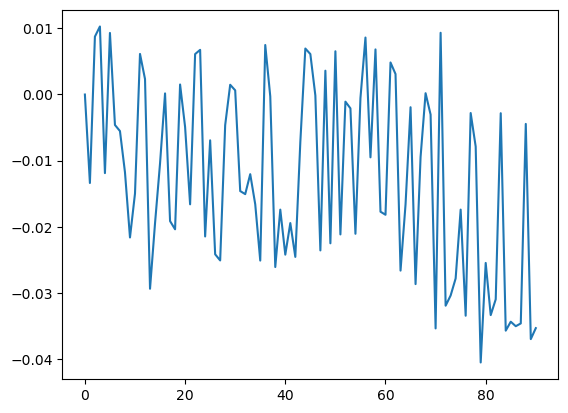

In [38]:
import seaborn as sns
sns.set()
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
palette = sns.color_palette("Blues_r", 4)
sns.scatterplot(x=X_sort[:,0], y=Y_sort[:,0], color=palette[0], edgecolor='w', linewidth=0.5)
plt.fill_between(X_sort[:,0], lower_CI_sort[:,0], upper_CI_sort[:,0], color=palette[1], alpha=0.4)
plt.plot(X_sort, lower_CI_sort, color=palette[2], lw=2,alpha=0.6)
plt.plot(X_sort, upper_CI_sort, color=palette[2], lw=2,alpha=0.6)
plt.plot(X_sort, mean, '-', color='orange', linewidth=2,label="Mean")
#    plt.plot(X_sort, mean, color=palette[3], linewidth=2, label="Mean")
plt.xlabel("X")
plt.ylabel("Y")
plt.ylim(ylim)
legend_elements = [
patches.Rectangle((0, 0), 1, 1, lw=0, color=palette[1], alpha=0.4, label="PI"),
lines.Line2D([0], [0], color='orange', lw=2, label="Mean")]
plt.legend(handles=legend_elements, loc=legend_loc)
#     plt.legend(loc='upper right')
plt.show()

In [46]:
import seaborn as sns
sns.set()
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
palette = sns.color_palette("Blues_r", 4)


def my_plot_FRED_MD(Y, Y_hat, V_hat, ylabel): 
    X = range(len(Y))
    lower_CI = Y_hat-np.sqrt(V_hat)
    upper_CI = Y_hat+np.sqrt(V_hat)


    sns.scatterplot(x = X, y=Y.reshape(-1), color=palette[0], edgecolor='w', linewidth=0.5)
    plt.fill_between(X, lower_CI.reshape(-1), upper_CI.reshape(-1), color=palette[1], alpha=0.4)
    plt.plot(X, lower_CI.reshape(-1), color=palette[2], lw=2,alpha=0.6)
    plt.plot(X, upper_CI.reshape(-1), color=palette[2], lw=2,alpha=0.6)
    plt.plot(X, Y_hat.reshape(-1), '-', color='orange', linewidth=2,label="Mean")
    #    plt.plot(X_sort, mean, color=palette[3], linewidth=2, label="Mean")
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    #plt.ylim(ylim)
    legend_elements = [
    patches.Rectangle((0, 0), 1, 1, lw=0, color=palette[1], alpha=0.4, label="PI"),
    lines.Line2D([0], [0], color='orange', lw=2, label="Mean")]
    plt.legend(handles=legend_elements, loc='best')
    plt.show()

/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.978021978021978
Mean bandwidth on test data for UTOPIA is 0.0006753001409418569


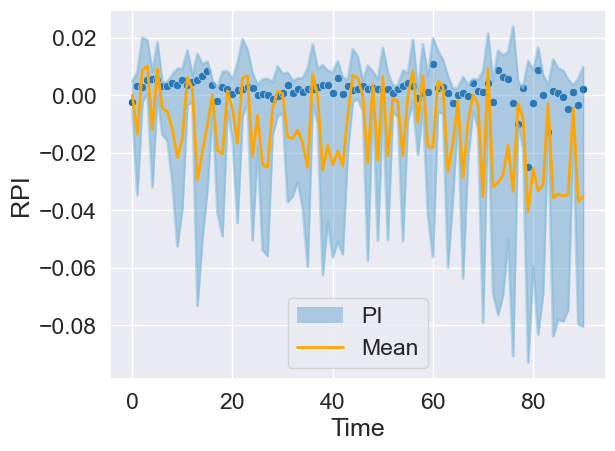

In [47]:
Data, Y_axis = FRED_MD_DATA_PREP('RPI', ncomps=2, error_comps=3)
X_t,Y_t,M_t,V_alpha_t, coverage_utopia, bandwidth_utopia = UTOPIA_FRED_MD_MULTIVARIATE(Data, shrink = True)
my_plot_FRED_MD(Y_t, M_t, V_alpha_t, 'RPI')

/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/all_functions.py:304: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


The overall coverage for UTOPIA is 0.989010989010989
Mean bandwidth on test data for UTOPIA is 0.0005910090281885534


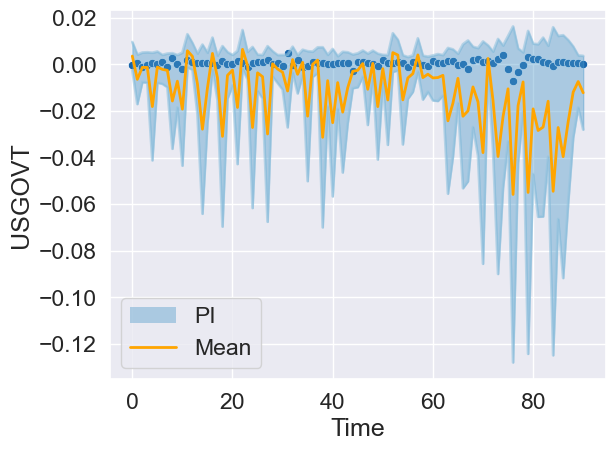

In [48]:
Data, Y_axis = FRED_MD_DATA_PREP('USGOVT', ncomps=2, error_comps=3)
X_t,Y_t,M_t,V_alpha_t, coverage_utopia, bandwidth_utopia = UTOPIA_FRED_MD_MULTIVARIATE(Data, shrink = True)
my_plot_FRED_MD(Y_t, M_t, V_alpha_t, 'USGOVT')